# Simulating absorption spectra in hydro simulations

KITP Program: [Building a Physical Understanding of Galaxy Evolution with Data-driven Astronomy](https://datadrivengalaxyevolution.github.io/) 

Jan 18, 2023

[Mahdi Qezlou](https://mahdiqezlou.github.io/)


[![Open this notebook in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DataDrivenGalaxyEvolution/galevo23-tutorials/blob/main/week-1/Large_scale_galaxy_formation_simulations_and_machine_learning_approaches_Part1_Simulated_absorption_spectra.ipynb)



## [MP-Gadget](https://github.com/MP-Gadget/MP-Gadget):

- We particularly use `MP-Gadget` simulation in this tutorial.
- It is derived from the main P-Gadget / Gadget-2, but it is scalable to a million nodes. 
- The largest run is ASTRID with L=250 cMpc/h and $2 \times 5500^3$ particles. 

<p align="center">
  <img src="https://raw.githubusercontent.com/mahdiqezlou/MP-Gadget_L15n256/main/images/ASTRID.png" width=100/>
</p>

The physics models :

- Pressure Entropy SPH and Density Entropy SPH
- Radiation background in the expansion
- [Massive neutrinos](https://ui.adsabs.harvard.edu/abs/2018MNRAS.481.1486B/abstract)
- Dark energy
- [ICs have species-dependent density and velocity transfer functions](https://ui.adsabs.harvard.edu/abs/2020JCAP...06..002B/abstract)
- Generic halo tracer particle seeding
- Various wind feedback and [blackhole feedback](https://ui.adsabs.harvard.edu/abs/2022MNRAS.510..531C/abstract) models
- Various star formation criteria
- Primordial and metal cooling using updated recombination rates from the Sherwood simulation.
- [Helium reionization](https://ui.adsabs.harvard.edu/abs/2020MNRAS.496.4372U/abstract)
- [Fluctuating UV background](https://ui.adsabs.harvard.edu/abs/2022MNRAS.512.3703B/abstract)



## Extracting spectra from simulations :


### Physics :


![](https://raw.githubusercontent.com/mahdiqezlou/MP-Gadget_L15n256/main/images/Voronoi_SPH.png)

- Each particle is an absorber with density and temperature estimated using the simulation's kernel, i.e. Voronoi for AREPO and SPH for Gadget
- Assuming ionization equilibrium with uniform UVB, we calculate the fraction of elements at different ionization states.
- To estimate the optical depth for each ion, we convolve the density with the Voigt profiles assigned to the absorber closest to the line of sight.



### `fake_spectra` :
Here, we introduce the [`fake_spectra`](https://github.com/sbird/fake_spectra.git) package to extract simulated spectra from `MP-Gadget` simulations. 

`fake_Spectra` is a small code for generating and analyzing simulated spectra from Arepo/Gadget. It is fast, parallel (Open-MP and MPI), and written in C++ and Python 3.


Let's install the required packages:

In [1]:
! pip install -q bigfile
# we need a few ubuntu libraries which are not installed on collab
! sudo apt-get -qq install -y libgsl-dev libboost-test-dev 
! pip install -q fake_spectra
! pip install -q astropy

Let's download a small `MP-Gadget` simulation with a box size of 15 cMpc/h and $250^3$ particles. 

In [2]:
! git clone https://github.com/mahdiqezlou/MP-Gadget_L15n256.git --quiet


It is in [`bigfile`](https://github.com/rainwoodman/bigfile) format which has python module to read/write in python. Very similar to hdf5, but more efficient when writing large simulations.


The simulation data sctructure is pretty standard. We only need the gas particles here.

```
MP-Gadget_L15n256
.
├── PART_020
│   ├── 0 # Gas
│   ├── 1 # Dark matter
│   └── [...]
└── [...]
```

#### Open-MP mode:

The cell below uses only a few cores to generate some spectra from the snapshot. `fake_spectra` is Open-MP parallel, so on HPC systems, you will get a speed boost if more cores on a single node are requested.

Let's get a few random spectra from this snapshot. The cell below calculates the HI column density and optical depth for $Ly\alpha$ and $Ly\beta$ lines. Similarly, you can get the spectra for all other simulated ions.

In [3]:
from fake_spectra.randspectra import RandSpectra

rr = RandSpectra(num=20, base="./MP-Gadget_L15n256/", numlos=3, thresh=0, res=5, savefile='spectra.hdf5')
# num is the snapshot number, i.e. PART_020
# numlos is the number of randomly positioned spectra you want
# pass thresh=0, otherwise only spectra with total column density above `thresh` are kept
# we set the pixel resolution 5 km/s
rr.get_tau(elem="H",ion=1,line=1215) # ion=1 refers to neutral gas, i.e. HI
                                     # line refers to the wavelength in Ansgtstrom
#Lyman-beta
rr.get_tau(elem="H",ion=1,line=1025)
rr.get_col_density("H",1)
#Save spectra to file
rr.save_file()

Reloading from snapshot (will save to:  ./MP-Gadget_L15n256/SPECTRA_020/spectra.hdf5  )
3  sightlines. resolution:  5.0079465240996  z= 2.1999999999999975


Below, we visualize the optical depth for a few of these spectra. The solid and dashed curves are $\tau_{Ly\alpha}$ and $\tau_{Ly\beta}$ along each spectrum respectively.

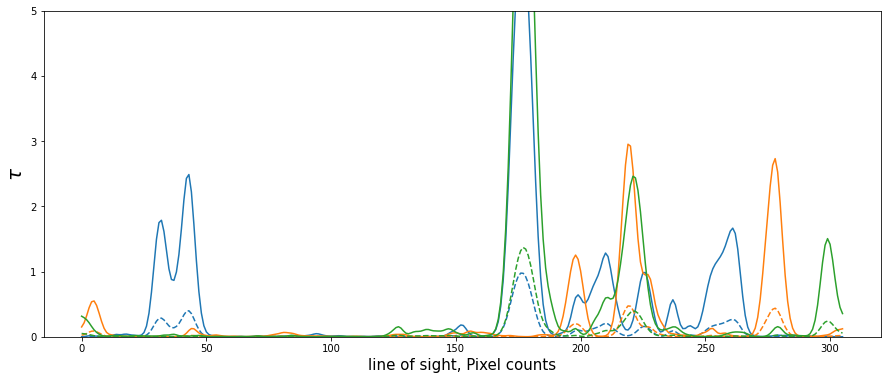

In [4]:
import h5py
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(15,6))
with h5py.File('./MP-Gadget_L15n256/SPECTRA_020/spectra.hdf5','r') as f:
  for i in range(3):
    ax.plot(f['tau/H/1/1215'][i,:], color='C'+str(i))
    ax.plot(f['tau/H/1/1025'][i,:], ls='--', color='C'+str(i))
  ax.set_ylim(0,5)
  ax.set_ylabel(r'$\tau$', fontsize=20)
  ax.set_xlabel('line of sight, Pixel counts', fontsize=15)

Also, the column dnesity :

<ipython-input-5-aa85a3cdf05d>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(f['colden/H/1/'][i,:]))


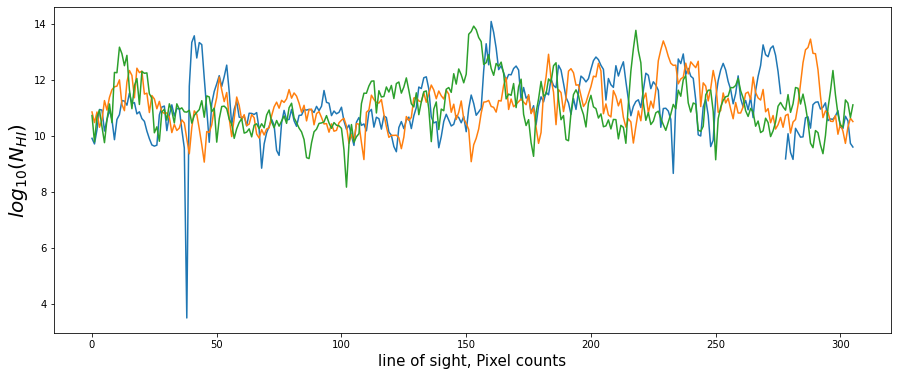

In [5]:
import numpy as np
fig, ax = plt.subplots(1,1, figsize=(15,6))
with h5py.File('./MP-Gadget_L15n256/SPECTRA_020/spectra.hdf5','r') as f:
  for i in range(3):
    ax.plot(np.log10(f['colden/H/1/'][i,:]))
  #ax.set_ylim(0,5)
  ax.set_ylabel(r'$log_{10}(N_{HI})$', fontsize=20)
  ax.set_xlabel('line of sight, Pixel counts', fontsize=15)

However, sometimes the neutral hydrogen fraction is not stored on the snapshots. `fake_spectra` calculates the HI fraction from gas density and temperature. 

The `rate_network` module calculates the HI fraction by assuming ionization equilibrium in the presence of a uniform ultraviolet background (UVB). It solves the collisional/photo-ionization and recombination rate network equations introduced by [Katz et al. (1996), eq. 28-32.](https://arxiv.org/abs/astro-ph/9509107).

 For this, a table containing the photo-ionization/heating of H and He is necessary. We use the table calculated from [radiative transfer simulations](https://arxiv.org/pdf/1903.08657.pdf), i.e. `treecool_file`.
 
 The self-shielding of dense gas is also implemented by modifying the photoionization rates to the fits provided by radiative transfer codes [`Rahmati et. a1l 2013`](https://ui.adsabs.harvard.edu/abs/2013MNRAS.430.2427R/abstract):

In [6]:
from fake_spectra.randspectra import RandSpectra
from fake_spectra.ratenetworkspectra import RateNetworkGas
# define global paramters, so people can change them!

rr = RandSpectra(num=20, base="./MP-Gadget_L15n256/", numlos=3, thresh=0, savefile='spectra.hdf5', gasprop=RateNetworkGas, 
                gasprop_args={"selfshield":True, "treecool_file":"./MP-Gadget_L15n256/TREECOOL_ep_2018p", "cool":"KWH","recomb":"Cen92"})
rr.get_tau("H",1,1215)
#Lyman-beta
rr.get_tau("H",1,1025)
rr.get_col_density("H",1)
#Save spectra to file
rr.save_file()

Reloading from snapshot (will save to:  ./MP-Gadget_L15n256/SPECTRA_020/spectra.hdf5  )
3  sightlines. resolution:  1.0002817469807295  z= 2.1999999999999975


#### MPI-Open-MP mode:

The `MPI` feature of `fake_spectra` helps speed up the post-processing of large snapshots, like the large run of ASTRID (a few TBs), using more nodes on HPC systems. 

It is implemented with the `mpi4py` python package.

In [7]:
! pip install -q mpi4py

 We only need to pass a `mpi4py.MPI` module to `fake_spectra` and run it with `mpirun` or `mpiexec`. The cell below writes a python file to be executed with `mpirun` or `mpiexec`:

In [8]:
%%sh 
cat > MP-Gadget_L15n256/run_mpi.py << EOF
from fake_spectra.randspectra import RandSpectra
# Only if you want the MPI feature; otherwise, MPI is None by default
from mpi4py import MPI
rr = RandSpectra(MPI=MPI, num=20, base="./MP-Gadget_L15n256/", numlos=80, thresh=0, res=5,  savefile='spectra.hdf5')
rr.get_tau("H",1,1215)
#Lyman-beta
rr.get_tau("H",1,1025)
rr.get_col_density("H",1)
#Save spectra to file
rr.save_file()
EOF

In [9]:
! mpirun --allow-run-as-root python MP-Gadget_L15n256/run_mpi.py

Reloading from snapshot (will save to:  ./MP-Gadget_L15n256/SPECTRA_020/spectra.hdf5  )
80  sightlines. resolution:  5.0079465240996  z= 2.1999999999999975


We are not sure how many CPUs we get on Colab, but when running on your won HPC, you can use N ranks with the flag `-np N`.

## Power spectra:
Now, having a few spectra, we can calculate the power spectra, which is the 
statistics to emulate in the second half of the tutorial (Ming-Feng's presentation.). 

The simulated optical depth for $Ly\alpha$ absorption requires a scaling to match the observed mean flux constrained by [Facher-Giguere et al. 2008](https://iopscience.iop.org/article/10.1086/592289).

Text(0, 0.5, 'P(k)')

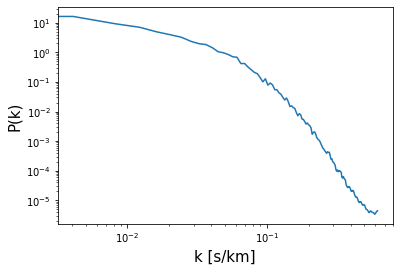

In [10]:
def get_mean_flux(z) :
    """ get the mean flux as function of z, constrained by Faucher-Giguere 2008
    z : redshift
    _________________
    Returns: mean flux
    """
    return np.exp(-0.001330*(1+z)**4.094)

from astropy.cosmology import Planck15 as cosmo
from fake_spectra import fluxstatistics as fs  

with h5py.File('./MP-Gadget_L15n256/SPECTRA_020/spectra.hdf5','r') as f:
  tau =  f['tau/H/1/1215'][:]
  z = f['Header'].attrs['redshift']
  boxsize = f['Header'].attrs['box']

# The boxsize in units of km/s
vmax = cosmo.H(z).value* boxsize/(1000*(1+z)*cosmo.h)
# The spectral resolution in units of km/s. The power spectrum is divided by this window
spec_res = vmax/tau.shape[1]
k, power_spec = fs.flux_power(tau, vmax= vmax, spec_res= spec_res,
                                  mean_flux_desired=get_mean_flux(z=z))

fig, ax = plt.subplots(1,1)
ax.plot(k, power_spec)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('k [s/km]', fontsize=15)
ax.set_ylabel('P(k)', fontsize=15)

Now, We hear from Ming-Feng telling us how to build a Gaussian Process emulator on these simulated powerspectra.